# Copyright : fast.ai - Jeremy Howard & Sylvain Gugger - 2020 (GPLv3)

Cellules de code et plan du notebook adaptées du livre :

Deep Learning for Coders with fastai & PyTorch de Jeremy Howard et Sylvain Gugger.

The code in the original notebooks (and thus the code in this notebook) is covered by the GPL v3 license; see the LICENSE file for details.

In [1]:
from fastai2.vision.all import *

In [2]:
# Utilitaire
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

# Classification d'images

## Distinction fine de 37 races de chiens et de chats

[The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)
*Omkar M Parkhi and Andrea Vedaldi and Andrew Zisserman and C. V. Jawahar*

Exploration du jeu de données :

In [5]:
path = untar_data(URLs.PETS)

In [4]:
path.ls()

(#2) [Path('/storage/data/oxford-iiit-pet/images'),Path('/storage/data/oxford-iiit-pet/annotations')]

In [5]:
images_list = (path/"images").ls()
images_list

(#7393) [Path('/storage/data/oxford-iiit-pet/images/american_bulldog_146.jpg'),Path('/storage/data/oxford-iiit-pet/images/japanese_chin_12.jpg'),Path('/storage/data/oxford-iiit-pet/images/Sphynx_247.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_158.jpg'),Path('/storage/data/oxford-iiit-pet/images/beagle_76.jpg'),Path('/storage/data/oxford-iiit-pet/images/shiba_inu_207.jpg'),Path('/storage/data/oxford-iiit-pet/images/Siamese_56.jpg'),Path('/storage/data/oxford-iiit-pet/images/keeshond_194.jpg'),Path('/storage/data/oxford-iiit-pet/images/miniature_pinscher_89.jpg'),Path('/storage/data/oxford-iiit-pet/images/leonberger_42.jpg')...]

In [6]:
filepath = images_list[1]
filepath.name

'japanese_chin_12.jpg'

In [7]:
def get_label_from_filename(filename):
    return re.findall(r'(.+)_\d+.jpg$', filename)

get_label_from_filename(filepath.name)

['japanese_chin']

In [8]:
img0 = Image.open(images_list[0])
img1 = Image.open(images_list[1])
img2 = Image.open(images_list[2])

print(img0.size, img1.size, img2.size)

print(get_label_from_filename(images_list[0].name),
      get_label_from_filename(images_list[1].name),
      get_label_from_filename(images_list[2].name))

(375, 500) (332, 500) (250, 201)
['american_bulldog'] ['japanese_chin'] ['Sphynx']


In [ ]:
show_image(img0)
show_image(img1)
show_image(img2)

Préparation des données à l'aide de l'API fastai2 **DataBlock** :

In [6]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

Quelles transformations sont appliquées pour augmenter la variété des données d'entrainement ?

In [11]:
[tranform.name for tranform in aug_transforms(size=224, min_scale=0.75)]

['AffineCoordTfm', 'LightingTfm', 'RandomResizedCropGPU']

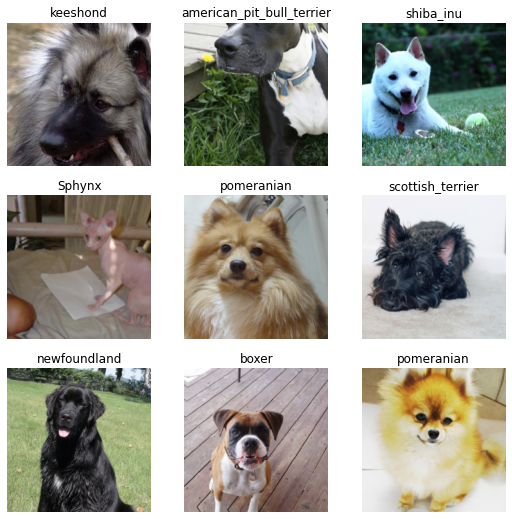

In [12]:
dls.show_batch()

## Augmentation des images d'entrainement - Stratégie de "presizing"

Nous avons besoin que nos images aient les mêmes dimensions, afin qu'elles puissent être assemblées en tenseurs pour être transmises au GPU. Nous voulons également minimiser le nombre de calculs d'augmentation distincts que nous effectuons. 

Pour optimiser les performances, nous devrions donc, dans la mesure du possible, fusionner nos transformations d'augmentation en un minimum de transformations (pour réduire le nombre de calculs et le nombre d'opérations avec perte) et transformer les images en tailles uniformes (pour exécuter efficacement les calculs sur le GPU).

Le défi est que, si les transformations d'augmentation sont réalisées après avoir redimensionné l'image, elles pourraient introduire des zones vides parasites, dégrader les données, ou les deux. Par exemple, la rotation d'une image de 45 degrés remplit les coins de vide, ce qui n'apprendra rien au modèle. De nombreuses opérations de rotation et de zoom nécessiteront une interpolation pour créer des pixels. Ces pixels interpolés sont dérivés des données de l'image originale mais sont toujours de moindre qualité.

Pour contourner ces défis, le **presizing** adopte deux stratégies :

1. Premièrement, redimensionner les images à des "dimensions relativement grandes", c'est-à-dire à des dimensions nettement supérieures à celles de la taille cible en entrée du modèle. 

2. Deuxièmement, fusionner toutes les opérations d'augmentation (y compris un redimensionnement à la taille cible finale) en une seule, et exécuter l'opération combinée sur le GPU une seule fois à la fin du traitement, plutôt que de les exécuter individuellement et d'interpoler plusieurs fois.

La première étape, le redimensionnement, crée des images suffisamment grandes pour qu'elles aient une marge de manœuvre qui permette d'autres transformations d'augmentation sur leurs régions intérieures sans créer de zones vides. Cette transformation fonctionne par redimensionnement en carré, en utilisant une grande taille de recadrage. Sur le jeu de données d'entraînement, la zone de recadrage est choisie au hasard, et la taille du recadrage est choisie pour couvrir toute la largeur ou la hauteur de l'image (la plus petite des deux).

Dans la deuxième étape, le GPU est utilisé pour toute les augmentations de données, et toutes les opérations potentiellement destructrices sont effectuées ensemble, avec une seule interpolation à la fin.

<img alt="Presizing on the training set" width="600" caption="Presizing on the training set" id="presizing" src="presizing.png">

Cette image montre les deux étapes :

1. *Réduire la largeur ou la hauteur totale* : exécuté dans `item_tfms`, donc c'est appliqué à chaque image individuelle avant qu'elle ne soit copiée sur le GPU. Utilisé pour s'assurer que toutes les images ont la même taille. Sur le jeu d'entrainement, la zone de recadrage est choisie au hasard. Sur le jeu de validation, le carré central de l'image est toujours choisi.

2. *Recadrage et augmentation aléatoires* : exécuté dans `batch_tfms`, donc c'est appliqué à un mini-batch en une seule fois sur le GPU, ce qui signifie que c'est rapide. Sur le jeu de validation, seul le redimensionnement à la taille finale nécessaire pour le modèle est réalisé. Sur le jeu d'entrainement, le recadrage aléatoire et toute autre augmentation sont effectuées en premier.

Pour mettre en œuvre ce processus dans fastai2, vous utilisez `Resize` comme transformation d'item avec une grande taille, et `RandomResizedCrop` comme une transformation de batch avec une plus petite taille. `RandomResizedCrop` sera ajouté automatiquement pour vous si vous incluez le paramètre `min_scale` dans votre fonction `aug_transforms`, comme vous le voyez dans l'appel `DataBlock` ci-dessus. Alternativement, vous pouvez utiliser `pad` ou `squish` au lieu de `crop` (par défaut) pour le `Resize` initial.

Vous pouvez voir dans cet exemple la différence entre une image qui a été zoomée, interpolée, tournée, puis interpolée à nouveau sur la droite (ce qui est l'approche utilisée par toutes les autres bibliothèques de deep learning), par rapport à une image qui a été zoomée et tournée en une seule opération, puis interpolée une seule fois sur la gauche (l'approche fastai2) :

In [13]:
# Création de batchs à partir d'un dataset de 100 images identiques
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([images_list[0]]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()

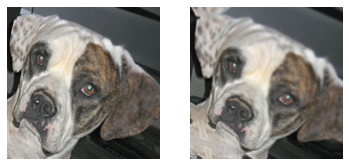

In [14]:
# Transformations réalisées les unes après les autres
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# Transformations réalisées dans un pipeline sur le GPU
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), 
                       Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)

# Comparaison des résultats
_,axs = subplots(1, 2)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

## Tester et mettre au point un DataBlock

In [15]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))

pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x374
  Pipeline: partial -> Categorize
    starting from
      /storage/data/oxford-iiit-pet/images/shiba_inu_98.jpg
    applying partial gives
      shiba_inu
    applying Categorize gives
      TensorCategory(33)

Final sample: (PILImage mode=RGB size=500x374, TensorCategory(33))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=500x374, TensorCategory(33))
    applying ToTensor gives
      (TensorImage of size 3x374x500, TensorC

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 374 and 375 in dimension 2 at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/TH/generic/THTensor.cpp:612

## Entrainer un premier modèle

In [16]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.507897,0.322442,0.104195,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.489585,0.326173,0.106901,00:33
1,0.308813,0.233517,0.070365,00:33


fastai2 a choisi une fonction de coût (loss function) automatiquement pour cette tâche de classification (détectée grace à la donnée y de type CategoryBlock en sortie) :

In [17]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Mesure de l'erreur de classification - Cross entropy loss

### Visualiser les activations en sortie du modèl et les labels attendus

In [18]:
x,y = dls.one_batch()

Visualiser les labels attendus - Category encoding :

In [19]:
y

TensorCategory([21, 30, 19, 26, 21, 32, 20, 26, 13,  8,  9, 34, 10, 10,  2, 18, 14, 30,
        30, 25, 31,  6, 25, 11, 32, 20,  3,  4,  5,  1,  7, 11,  3, 23, 32, 23,
        29, 14, 11, 10,  0,  5, 24, 32, 31, 10,  7, 35, 23, 11, 28,  0, 17, 25,
        36,  9,  3, 18, 11, 28, 31,  3, 16,  0], device='cuda:0')

In [20]:
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

In [21]:
y[0].item(), dls.vocab[y[0]]

(21, 'great_pyrenees')

In [22]:
labels = [dls.vocab[cat_index] for cat_index in y]
labels[:10]

['great_pyrenees',
 'saint_bernard',
 'english_setter',
 'miniature_pinscher',
 'great_pyrenees',
 'scottish_terrier',
 'german_shorthaired',
 'miniature_pinscher',
 'american_pit_bull_terrier',
 'Ragdoll']

Visualiser les activations en sortie du modèle - One hot encoding :

In [23]:
print(x.shape, y.shape)

preds,_ = learn.get_preds(dl=[(x,y)])

print(preds.shape)
preds[0]

torch.Size([64, 3, 224, 224]) torch.Size([64])


torch.Size([64, 37])


tensor([9.8756e-10, 1.9553e-10, 1.4473e-08, 2.0062e-10, 5.2382e-10, 3.6264e-09,
        4.5120e-08, 2.9502e-09, 3.8669e-08, 6.0781e-10, 4.7526e-10, 8.8145e-11,
        2.5693e-09, 1.1304e-08, 2.7833e-08, 3.9908e-09, 5.5590e-11, 2.7556e-10,
        6.8074e-10, 9.5566e-09, 3.1177e-09, 9.9999e-01, 1.9181e-10, 1.8102e-09,
        1.0081e-09, 4.4306e-07, 6.4631e-10, 1.5275e-07, 2.8824e-09, 1.0554e-09,
        4.8801e-06, 8.9301e-06, 4.5577e-10, 2.1570e-08, 4.5409e-10, 9.6797e-08,
        2.3094e-10])

In [24]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

### Equivalent de sigmoid pour plus de 2 catégories : Softmax

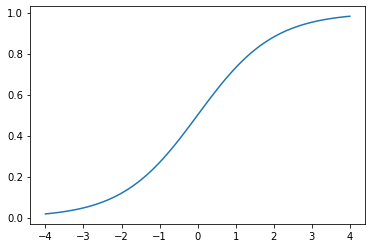

In [25]:
plot_function(torch.sigmoid, min=-4,max=4)

Exemple : activations pour 6 images, 3 classes possibles.

In [62]:
acts = torch.randn((6,3))*2
acts

tensor([[ 1.6101, -2.2267, -2.5847],
        [ 0.3377, -1.6652, -1.6259],
        [ 1.9401, -1.3515,  0.4085],
        [-0.0530,  0.1660,  0.8440],
        [ 0.6837, -5.4032,  0.1332],
        [-1.8240,  0.7364,  1.4099]])

In [63]:
acts.sigmoid()

tensor([[0.8334, 0.0974, 0.0701],
        [0.5836, 0.1591, 0.1644],
        [0.8744, 0.2056, 0.6007],
        [0.4868, 0.5414, 0.6993],
        [0.6646, 0.0045, 0.5333],
        [0.1390, 0.6762, 0.8038]])

In [64]:
acts.sum(1)

tensor([-3.2014, -2.9534,  0.9970,  0.9571, -4.5863,  0.3224])

Définition de la fonction Softmax :
```python
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)
```

En prenant l'exponentielle, on s'assure que tous nos chiffres sont positifs, et en divisant ensuite par la somme, on s'assure d'avoir des chiffres qui s'additionnent pour donner un. 

L'exponentielle a également une propriété intéressante : si l'un des nombres de nos activations x est légèrement plus grand que les autres, l'exponentielle va l'amplifier (puisqu'elle croît ... exponentiellement), ce qui signifie que dans le softmax, ce nombre sera plus proche de 1.

In [65]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.9647, 0.0208, 0.0145],
        [0.7841, 0.1058, 0.1101],
        [0.7978, 0.0297, 0.1725],
        [0.2129, 0.2650, 0.5221],
        [0.6333, 0.0014, 0.3652],
        [0.0254, 0.3291, 0.6454]])

In [66]:
sm_acts.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

Intuitivement, la fonction Softmax veut vraiment choisir une classe parmi les autres, c'est donc idéal pour entrainer un classifier quand on sait que chaque image a un label bien défini.

NB : cette fonction peut être moins adaptée en production, car vous pourriez vouloir que votre modèle vous dise parfois qu'il ne reconnaît aucune des classes qu'il a vues pendant l'entrainement, et qu'il ne choisisse pas une classe parce qu'elle a un score d'activation légèrement plus élevé. Dans ce cas, il peut être préférable d'entrainer un modèle en utilisant plusieurs activations de sortie binaires, chacune utilisant une fonction sigmoïde.

### Mesure de distance aux labels pour plus de 2 catégories : Negative Log Likelihood

In [67]:
labels = tensor([0,1,0,2,1,0])

In [68]:
sm_acts

tensor([[0.9647, 0.0208, 0.0145],
        [0.7841, 0.1058, 0.1101],
        [0.7978, 0.0297, 0.1725],
        [0.2129, 0.2650, 0.5221],
        [0.6333, 0.0014, 0.3652],
        [0.0254, 0.3291, 0.6454]])

In [69]:
idx = range(6)
sm_acts[idx, labels]

tensor([0.9647, 0.1058, 0.7978, 0.5221, 0.0014, 0.0254])

In [83]:
df = pd.DataFrame(sm_acts, columns=["cat0","cat1","cat2"])
df['label'] = labels
df['idx'] = idx
df['dist'] = 1-sm_acts[range(6), labels]
t = df.style.hide_index()
df

,cat0,cat1,cat2,label,idx,dist
0,0.964659,0.020800,0.014541,0,0,0.035341
1,0.784140,0.105808,0.110052,1,1,0.894192
2,0.797836,0.029675,0.172490,0,2,0.202164
3,0.212900,0.265023,0.522077,2,3,0.477923
4,0.633334,0.001439,0.365227,1,4,0.998561
5,0.025432,0.329123,0.645445,0,5,0.974568


In [79]:
1 - sm_acts[idx, labels]

tensor([0.0353, 0.8942, 0.2022, 0.4779, 0.9986, 0.9746])

In [82]:
1 + F.nll_loss(sm_acts, labels, reduction='none')

tensor([0.0353, 0.8942, 0.2022, 0.4779, 0.9986, 0.9746])

### Appliquer la fonction `log`

Au fur et à mesure qu'on se rapproche d'une activation normalisée 1, chaque fois qu'on divise l'erreur restante par deux, le gain sur la distance (loss functions) devient de plus en plus petit, insuffisant pour encourager l'ajustement des paramètres du modèle.

De manière à préserver un gain de distance constant chaque fois qu'on divise l'erreur restante par 2, on prend le LOG des activations normalisées pour constituer la fonction de coût.

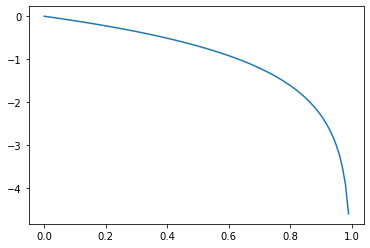

In [77]:
plot_function(lambda sm_act: torch.log(1 - sm_act), min=0,max=1)

La combinaison de l'application de Softmax pour normaliser les activations, puis de la fonction Negative Log Likelihood pour calculer le LOG des distances aux labels, définit la fonction Cross Entropy.

L'intérêt de cette fonction de coût est que le gradient utilisé pour diriger l'ajustement des paramètres est proportionnel à la différence entre les activations et les labels?

In [84]:
loss_func = nn.CrossEntropyLoss()

In [85]:
loss_func(acts, labels)

tensor(2.2289)

In [86]:
F.cross_entropy(acts, labels)

tensor(2.2289)

In [87]:
nn.CrossEntropyLoss(reduction='none')(acts, labels)

tensor([0.0360, 2.2461, 0.2259, 0.6499, 6.5436, 3.6717])

## Interprétation d'un modèle de classification

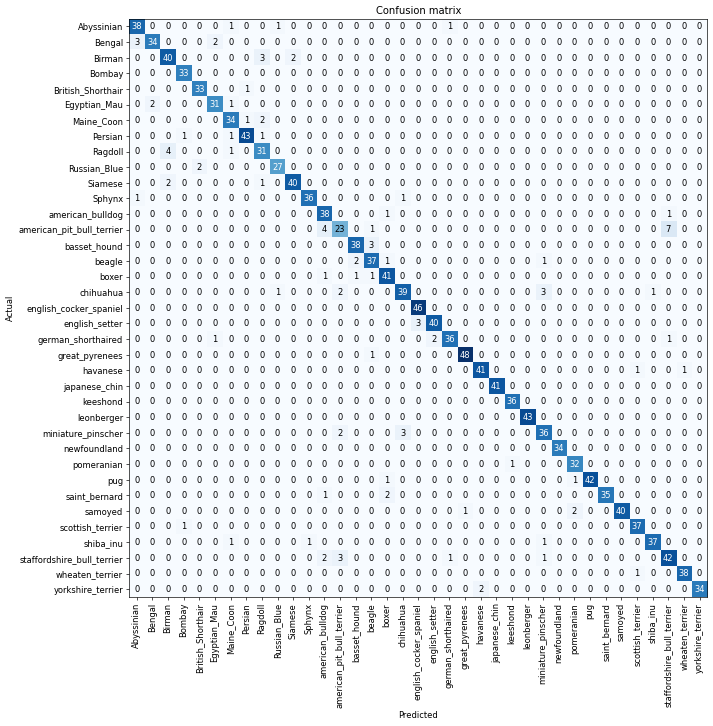

In [88]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [92]:
interp.most_confused(min_val=4)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Ragdoll', 'Birman', 4),
 ('american_pit_bull_terrier', 'american_bulldog', 4)]

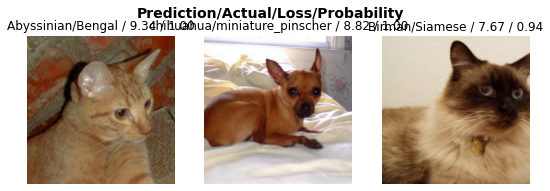

In [94]:
interp.plot_top_losses(k=3)

## Améliorer notre modèle

### Learning rate finder

In [95]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,2.575385,3.880570,0.441137,00:31


epoch,train_loss,valid_loss,error_rate,time
0,3.439296,2.087398,0.583221,00:36
1,1.735350,44.970966,0.263870,00:36


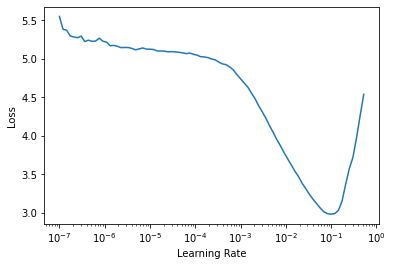

In [96]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [97]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 3.63e-03


In [98]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=6e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.041800,0.436562,0.116373,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.684395,0.583314,0.161705,00:34
1,0.420014,0.280530,0.092016,00:35


### Unfreezing et transfer learning

In [7]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.146381,0.350496,0.116373,00:56
1,0.523010,0.260834,0.084574,00:54
2,0.316822,0.240947,0.071719,00:54


1-cycle learning rate policy

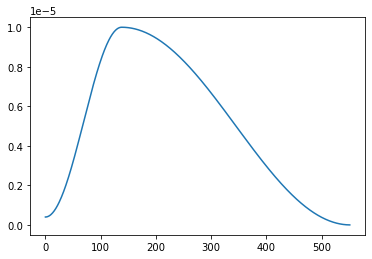

In [25]:
lrs = learn.recorder.lrs
plt.plot(list(range(len(lrs))), lrs, label='lr')

Paramètres du modèle "resnet34" (PyTorch) :

In [8]:
L([params.shape for params in learn.model.parameters()])

(#114) [torch.Size([64, 3, 7, 7]),torch.Size([64]),torch.Size([64]),torch.Size([64, 64, 3, 3]),torch.Size([64]),torch.Size([64]),torch.Size([64, 64, 3, 3]),torch.Size([64]),torch.Size([64]),torch.Size([64, 64, 3, 3])...]

Nombre de paramètres du modèle à ajuster : **21.8 millions** !

In [9]:
array([params.numel() for params in learn.model.parameters()]).sum()

21830976

Avons-nous réussi à ajuster 21.8 millions de paramètres avec seulement 7000 exemples d'animaux ?

Non, nous avons réutilisé un modèle entrainé sur ImageNet, et réalisé du transfer learning.

In [23]:
learn.fine_tune??

RAPPEL

L'arrangement spécifique de blocs de calcul choisi pour modéliser une tâche donnée est appelé **architecture** du réseau de neurones.

L'architecture d'un réseau de neurone est composée de deux parties :
- d'un corps (**body ou backbone**) qui **extrait les caractéristiques utiles** des données en entrée : distillation de l'information pour apprendre une **représentation** utile des données
- d'une tête (**head**) qui s'appuie sur ces caractéristiques pertinentes pour **réaliser la prédiciton**

Visualisation des caractéristiques extraites par les niveaux successifs d'un **réseau de neurones convolutionnel (CNN)** dans une application de vision :

[Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf)

[A guided tour of the first five layers of InceptionV1, taxonomized into neuron groups](https://distill.pub/2020/circuits/early-vision/)

Les niveaux supérieurs combinent les caractéristiques des niveaux inférieurs pour produire des caractéristiques de plus en plus complexes.

Les premiers niveaux extraient des caractéristiques basiques, intrinsèques au type de données fourni en entrée.

Les derniers niveaux produisent des caractéristiques complexes, spécialisées pour la prédicition à réaliser.

Si les données d'entrée sont similaires, les premiers niveaux sont réutilisables quasiment sans modification.

Plus on progresse dans les niveaux moins l'information est réutilisable d'une tâche à l'autre.

Que se passe-t-il dans la fonction cnn_learner ?

Examinons l'architecture "resnet34" :

In [10]:
[(name,type(module)) for name,module in learn.model.named_children()]

[('0', torch.nn.modules.container.Sequential),
 ('1', torch.nn.modules.container.Sequential)]

In [16]:
[(name,type(module)) for name,module in list(learn.model.children())[0].named_children()]

[('0', torch.nn.modules.conv.Conv2d),
 ('1', torch.nn.modules.batchnorm.BatchNorm2d),
 ('2', torch.nn.modules.activation.ReLU),
 ('3', torch.nn.modules.pooling.MaxPool2d),
 ('4', torch.nn.modules.container.Sequential),
 ('5', torch.nn.modules.container.Sequential),
 ('6', torch.nn.modules.container.Sequential),
 ('7', torch.nn.modules.container.Sequential)]

In [15]:
[(name,type(module)) for name,module in list(list(learn.model.children())[0].children())[6].named_children()]

[('0', torchvision.models.resnet.BasicBlock),
 ('1', torchvision.models.resnet.BasicBlock),
 ('2', torchvision.models.resnet.BasicBlock),
 ('3', torchvision.models.resnet.BasicBlock),
 ('4', torchvision.models.resnet.BasicBlock),
 ('5', torchvision.models.resnet.BasicBlock)]

In [13]:
[(name,type(module)) for name,module in list(learn.model.children())[1].named_children()]

[('0', fastai2.layers.AdaptiveConcatPool2d),
 ('1', fastai2.layers.Flatten),
 ('2', torch.nn.modules.batchnorm.BatchNorm1d),
 ('3', torch.nn.modules.dropout.Dropout),
 ('4', torch.nn.modules.linear.Linear),
 ('5', torch.nn.modules.activation.ReLU),
 ('6', torch.nn.modules.batchnorm.BatchNorm1d),
 ('7', torch.nn.modules.dropout.Dropout),
 ('8', torch.nn.modules.linear.Linear)]

=> fastai réutilise le corps déjà entrainé (paramètres téléchargés), et a ajouté une nouvelle "tête" spécifique à cette tâche (paramètres initialisés au hasard).

Extrait de la documentation fastai2 :

To do transfer learning, you need to pass a splitter to Learner. 

This should be a function taking the model and returning a collection of parameter groups, e.g. a list of list of parameters.

```python
def  _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)
```

Les paramètres du modèle sont divisés en trois groupes :
- première moitié du corps
- deuxième moitié du corps
- tête

In [18]:
[(len(param_group),type(param_group[0])) for param_group in learn.opt.param_groups]

[(48, torch.nn.parameter.Parameter),
 (60, torch.nn.parameter.Parameter),
 (6, torch.nn.parameter.Parameter)]

In [19]:
param_group2 = learn.opt.param_groups[2]
[params.data.shape for params in param_group2]

[torch.Size([1024]),
 torch.Size([1024]),
 torch.Size([512, 1024]),
 torch.Size([512]),
 torch.Size([512]),
 torch.Size([37, 512])]

In [20]:
learn.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.9054607491852948e-06)

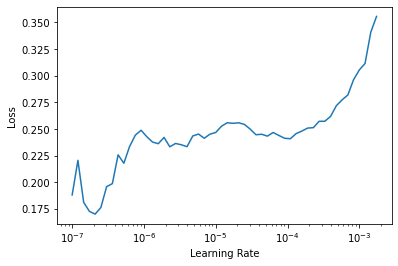

In [21]:
learn.lr_find()

In [22]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.251922,0.237243,0.073072,01:12
1,0.255534,0.231387,0.066982,01:11
2,0.228372,0.218489,0.062923,01:11
3,0.195737,0.221102,0.064953,01:11
4,0.180895,0.219237,0.064953,01:11
5,0.176399,0.217272,0.062246,01:11


### Discriminative learning rates

In [61]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.115057,0.337810,0.105548,00:26
1,0.539760,0.291335,0.092016,00:26
2,0.332870,0.237753,0.077131,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.267482,0.234121,0.073072,00:31
1,0.254349,0.229980,0.072395,00:31
2,0.229564,0.231214,0.073748,00:31
3,0.203906,0.224533,0.074425,00:31
4,0.189361,0.218713,0.069012,00:31
5,0.180013,0.213483,0.065629,00:31
6,0.159577,0.213275,0.064276,00:31
7,0.149588,0.208382,0.062923,00:31
8,0.140246,0.211009,0.065629,00:31
9,0.130604,0.209260,0.062246,00:31


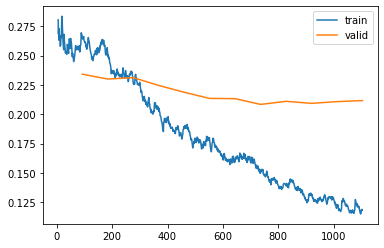

In [62]:
learn.recorder.plot_loss()

### Pendant combien de temps entrainer ? Sélectionner le nombre d'époques

Vous constaterez souvent que vous êtes limité par le temps, plutôt que par la capacité de généralisation et la qualité de prédiction, lorsque vous choisissez le nombre d'époques pour lesquelles vous devez entraîner le modèle. 

La première approche pour l'entrainement devrait donc consister à choisir simplement un nombre d'époques qui vous permettront de réaliser l'entrainement dans le laps de temps que vous êtes prêt à attendre. Examinez les graphiques de diminution de la fonction de coût sur les jeux d'entrainement et de validation, comme indiqué ci-dessus, et en particulier vos métriques de performances. Si vous constatez qu'elles s'améliorent encore, même dans vos dernières époques, vous savez que vous ne vous n'avez pas entrainé le modèle trop longtemps.

D'un autre côté, vous pouvez très bien voir que les métriques de performance que vous avez choisies se détériorent vraiment à la fin de l'entrainement. N'oubliez pas que ce n'est pas seulement la fonction de coût que nous cherchons à minimiser, mais aussi vos métriques de performance que nous cherchons à optimiser. La fonction de coût est juste un artifice que nous utilisions pour piloter l'ajustement des paramètres ; ce n'est pas vraiment la chose qui nous intéresse dans la pratique.

Avant qu'on utilise l'entrainement 1-cycle, il était très courant de sauvegarder le modèle à la fin de chaque époque, puis de sélectionner celui qui avait la meilleure précision, parmi tous les modèles sauvegardés à chaque époque. C'est ce qu'on appelle "early stopping". 

Cependant, avec une entrainement 1-cycle, il est très peu probable que vous obteniez la meilleure réponse de cette manière, car les époques du milieu se produisent avant que la learning rate n'ait eu la chance d'atteindre les petites valeurs, où on peut vraiment trouver le meilleur résultat. 

Par conséquent, si vous constatez que vous avez sur-spécialisé le modèle, ce que vous devez faire en réalité est de redémarrer l'entrainement de votre modèle à partir de zéro, et de sélectionner un nombre total d'époques en fonction de l'endroit où vos meilleurs résultats précédents ont été trouvés.

Si nous avons du temps pour entraîner sur plus d'époques, nous pouvons utiliser ce temps pour entraîner plus de paramètres, c'est-à-dire utiliser une architecture plus profonde.

### Utiliser une architecture plus profonde

En général, un modèle avec plus de paramètres peut modéliser vos données avec plus de précision. (Il y a beaucoup, beaucoup de réserves à cette généralisation, et cela dépend des spécificités des architectures que vous utilisez, mais c'est une règle empirique raisonnable pour l'instant). Pour la plupart des architectures que nous allons voir dans ce livre, vous pouvez en créer des versions plus grandes en ajoutant simplement des niveaux supplémentaires. Cependant, comme nous voulons utiliser des modèles pré-entrainés, nous devons nous assurer que nous choisissons un nombre de niveaux qui a déjà été pré-entrainé pour nous.

C'est pourquoi, en pratique, les architectures ont tendance à se présenter sous la forme d'un petit nombre de variantes. Par exemple, l'architecture resnet que nous utilisons dans ce chapitre se décline en 18, 34, 50, 101 et 152 niveaux, pré-entrainés sur ImageNet. 

Une version plus puissante (plus de niveaux et de paramètres ; parfois décrits comme la "capacité" d'un modèle) d'un resnet pourra toujours nous donner une meilleure erreur d'entraînement, mais elle peut souffrir davantage d'une sur-spécialisation (overfitting).

En général, un modèle plus grand a la capacité de mieux saisir les relations réelles sous-jacentes dans vos données, et aussi de saisir et de mémoriser les détails spécifiques de vos images individuelles.

Cependant, l'utilisation d'un modèle plus profond va nécessiter plus de mémoire GPU, et nous devrons donc peut-être réduire la taille de nos mini-batchs pour éviter les erreurs de mémoire. 

  Cuda runtime error: out of memory

Vous devrez peut-être redémarrer votre notebook à ce moment-là, et la solution consiste à utiliser une taille de batch plus petite, ce qui signifie que nous ferons passer des groupes d'images plus petits à tout moment dans notre modèle. Nous pouvons passer la taille de lot que nous voulons à l'appel créant nos DataLoaders avec bs=.

L'autre inconvénient des architectures plus profondes est qu'il faut beaucoup plus de temps pour les entraîner. Une chose qui peut accélérer beaucoup les choses est la diminution de la précision des calculs (32 bits -> 16 bits). Il s'agit d'utiliser des nombres moins précis (demi-précision en virgule flottante, également appelée fp16) lorsque cela est possible pendant l'entraînement. Au moment où nous écrivons ces lignes (début 2020), presque tous les GPU NVIDIA actuels prennent en charge une capacité spéciale appelée "tensor cores" qui peut accélérer considérablement (2x-3x) l'entraînement des réseaux neuronaux. Ils nécessitent également beaucoup moins de mémoire GPU. Pour activer cette fonction dans fastai, il suffit d'ajouter to_fp16() après la création de votre Learner (vous devez également importer le module).

In [63]:
#from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate) #.to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.273174,0.285852,0.089986,00:45
1,0.565775,0.264977,0.080514,00:43
2,0.432513,0.252678,0.081191,00:43


epoch,train_loss,valid_loss,error_rate,time
0,0.286545,0.242117,0.081867,01:05
1,0.303293,0.379559,0.108931,00:57
2,0.253836,0.267058,0.079161,00:57
3,0.158468,0.224737,0.063599,00:57
4,0.094714,0.225613,0.062246,00:57
5,0.054199,0.215326,0.059540,00:57
